# Libraries

In [ ]:
from google.colab import drive
from google.colab import data_table

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pickle
import os
import statistics

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import *
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA


import tensorflow as tf
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import initializers, regularizers, constraints, layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Load dataset & Data Pre-Processing

In [ ]:
dum = 'obesity_dataset.p'
df_tot = pickle.load( open( f"/content/gdrive/MyDrive/IA/Dataset/dumps/{dum}", "rb" ))

seed = 42
ratio_test = 0.6
ratio_val  = 0.8

# dizionario per il dataset, il dataset ridotto e immagini
X = {
      'ds':  {},
      'tab': {},
      'img': {}
    }

# dizionario per le label
Y = {}

X_train, X['ds']['test'] = train_test_split(
                                              df_tot,
                                              test_size = (1 - ratio_test),
                                              random_state = seed)

X['ds']['train'], X['ds']['validation'] = train_test_split(
                                                            X_train,
                                                            test_size = (1 - ratio_val),
                                                            random_state = seed)
# ripristino degli indici del DS
X['ds']['train'] = X['ds']['train'].sample(frac=1).reset_index(drop=True)
X['ds']['validation'] = X['ds']['validation'].sample(frac=1).reset_index(drop=True)
X['ds']['test'] = X['ds']['test'].sample(frac=1).reset_index(drop=True)

# aggiunta label
Y['train']      = np.asarray(X['ds']['train']['OBESE'])
Y['validation'] = np.asarray(X['ds']['validation']['OBESE'])
Y['test']       = np.asarray(X['ds']['test']['OBESE'])

In [ ]:
def lista_9_features(X):
  l = list(zip( X.Weight.values, 
                X.FHO.values, 
                X.FAVC.values, 
                X.CAEC.values, 
                X.Age.values, 
                X.FCVC.values, 
                X.Height.values, 
                X.CH2O.values, 
                X.NCP.values))
  return l

# Modalità di preprocessing per la creazione di un DS a 9 colonne:
#   1: PCA
#   2: Features Più Discriminanti
M = 2
if M == 1:
  pca = PCA(n_components = 9)
  pc_train       = pca.fit_transform(X['ds']['train'].drop('OBESE', axis = 1).values)
  pc_validation  = pca.fit_transform(X['ds']['validation'].drop('OBESE', axis = 1).values)
  pc_test        = pca.fit_transform(X['ds']['test'].drop('OBESE', axis = 1).values)

  X['tab']['train']      = pd.DataFrame(data = pc_train, columns = range(1,10))
  X['tab']['validation'] = pd.DataFrame(data = pc_validation, columns = range(1,10))
  X['tab']['test']       = pd.DataFrame(data = pc_test, columns = range(1,10))
else:
  columns = ['Weight', 'FHO', 'FAVC', 'CAEC', 'Age', 'FCVC', 'Height', 'CH2O', 'NCP']

  X['tab']['train']      = pd.DataFrame(lista_9_features(X['ds']['train']), columns = columns) 
  X['tab']['validation'] = pd.DataFrame(lista_9_features(X['ds']['validation']), columns = columns) 
  X['tab']['test']       = pd.DataFrame(lista_9_features(X['ds']['test']), columns = columns) 

## Create images with the TAC method

In [ ]:
input_res   = (224, 224)
class_names = ['Healty', 'Sick']
modality    = ['train', 'validation', 'test']
img_RAW     = cv2.imread("/content/gdrive/MyDrive/IA/IMGs/lena.tiff")

params = {
    'length_train'      : len(X['ds']['train']),
    'length_validation' : len(X['ds']['validation']),
    'length_test'       : len(X['ds']['test']),
    'x' : input_res[0],                                
    'y' : input_res[1], 
    'n_channels' : 3
}

dim = (params['x'],params['y'])

modality = ['train', 'validation', 'test']

kernels = {}
for mode in modality:
  N = params[f'length_{mode}']
  x = np.empty((N, params['y'],params['x'], params['n_channels']))
  i = 0
  for index, row in (X['tab'][mode].iterrows()):
    kernel_a = row.values
    kernel_a = kernel_a - statistics.mean(kernel_a)
    kernel   = np.array(kernel_a).reshape(3, 3)

    dst = cv2.filter2D(img_RAW, -1, kernel)

    image = cv2.resize(dst, dim)
    image = image/255
    image = image.astype(np.float32)

    x[i,:,:,:] = image
    i += 1
  X['img'][mode] = x


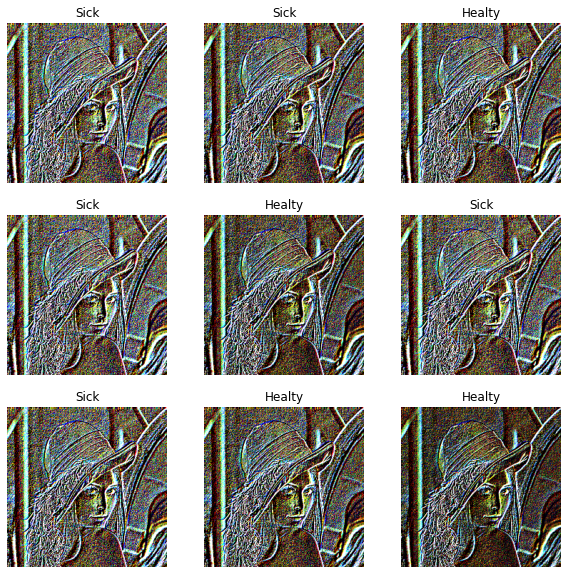

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X['img']['validation'][i,:,:,:])
  plt.title(class_names[Y['validation'][i]])
  plt.axis("off")
plt.show()

## Explore splitting

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


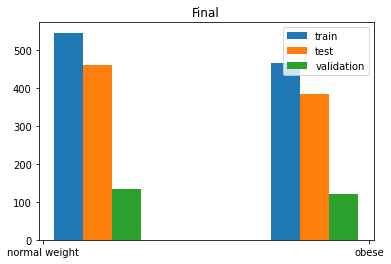


-> train set: 1012 | test set: 845 | validation set: 254


-> train set: 1012 | test set: 845 | validation set: 254



In [ ]:
# plot the labels's distribution
plt.hist([Y['train'], Y['test'], Y['validation']], bins=3, label=['train', 'test', 'validation'])
plt.xticks([0,1],['normal weight','obese'])
plt.legend(loc='upper right')
plt.title('Final')
plt.show()

# print the lengths
len_train = len(X['img']['train'])
len_test  = len(X['img']['test'])
len_vali  = len(X['img']['validation'])
print(f'\n-> train set: {len_train} | test set: {len_test} | validation set: {len_vali}\n')

len_train = params['length_train']
len_test  = params['length_test']
len_vali  = params['length_validation']
print(f'\n-> train set: {len_train} | test set: {len_test} | validation set: {len_vali}\n')

# CNN 

In [ ]:
train_labels = Y['train']
train_labels = tf.one_hot(train_labels, 2)

validation_labels = Y['validation']
validation_labels = tf.one_hot(validation_labels, 2)

test_labels = Y['test']
test_labels = tf.one_hot(test_labels, 2)

In [ ]:
params['batch_size'] = 8
params["learningRate"] = 1e-4
params["nEpoches"] = 100

## Create Models

In [ ]:
mode = 'ResNet'
#mode = 'VGG16'
if mode == 'ResNet':
  res_conv = tf.keras.applications.resnet50.ResNet50(
      include_top=False, weights='imagenet',
      input_shape=(input_res[0], input_res[1], 3)
  )

  model = models.Sequential()
  model.add(res_conv)
    
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(2, activation='sigmoid'))

  opt = Adam(learning_rate = params["learningRate"])
  model.compile(optimizer = opt, loss='binary_crossentropy', metrics=['accuracy'])

  model.build((None, input_res[0], input_res[1], 3)) 
elif mode == 'VGG16':
  vgg_conv = VGG16( input_shape = (input_res[0], input_res[1], 3), # Shape of our images
                    include_top = False, # Leave out the last fully connected layer
                    weights = 'imagenet')

  model = models.Sequential()
  model.add(vgg_conv)
    
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(2, activation='sigmoid'))

  opt = Adam(learning_rate = params["learningRate"])
  model.compile(optimizer = opt, loss='binary_crossentropy', metrics=['accuracy'])
else:
  vgg_conv = VGG19( input_shape = (input_res[0], input_res[1], 3), # Shape of our images
                    include_top = False, # Leave out the last fully connected layer
                    weights = 'imagenet')

  '''
  for layer in vgg_conv.layers[:4]:
    layer.trainable = False
  for layer in vgg_conv.layers:       
    print(layer, layer.trainable)
  '''

  model = models.Sequential()
  model.add(vgg_conv)
    
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(2, activation='sigmoid'))

  opt = Adam(learning_rate = params["learningRate"])
  model.compile(optimizer = opt, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               12845184  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 36,433,154
Trainable params: 36,380,034
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
steps_per_epoch  = np.ceil(params["length_train"]/params["batch_size"])
validation_steps = np.ceil(params['length_validation']/params["batch_size"])

trdata = ImageDataGenerator()
traindata = trdata.flow(X['img']['train'], y = train_labels, batch_size = params['batch_size'], shuffle = True, seed=seed)
tsdata = ImageDataGenerator()
testdata = trdata.flow(X['img']['validation'], y = validation_labels, batch_size = params['batch_size'], shuffle = True, seed=seed)

callbacks_list = [
                  ModelCheckpoint('./LOLLO_best_weights.hdf5', 
                                monitor='val_loss', 
                                verbose=1, 
                                save_best_only=True, 
                                mode='auto'),
                  ReduceLROnPlateau(monitor='val_loss',
                                    mode='min', 
                                    factor=0.1, 
                                    patience=10,
                                    verbose=1,),
                  EarlyStopping(monitor='val_loss', 
                                patience=20, 
                                restore_best_weights=False),
                  ]

history = model.fit( traindata,  
                    steps_per_epoch = steps_per_epoch,
                    validation_data=testdata, 
                    epochs=params["nEpoches"],
                    validation_steps = validation_steps, 
                    callbacks=[callbacks_list])

Epoch 1/100
127/127 [==============================] - 34s 87ms/step - loss: 0.5326 - accuracy: 0.8409 - val_loss: 39.4639 - val_accuracy: 0.5236

Epoch 00001: val_loss improved from inf to 39.46392, saving model to ./LOLLO_best_weights.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
127/127 [==============================] - 9s 74ms/step - loss: 0.3094 - accuracy: 0.8458 - val_loss: 104.3185 - val_accuracy: 0.5236

Epoch 00002: val_loss did not improve from 39.46392
Epoch 3/100
127/127 [==============================] - 9s 74ms/step - loss: 0.3641 - accuracy: 0.8468 - val_loss: 143.8615 - val_accuracy: 0.5236

Epoch 00003: val_loss did not improve from 39.46392
Epoch 4/100
127/127 [==============================] - 9s 74ms/step - loss: 0.4228 - accuracy: 0.7964 - val_loss: 496.0106 - val_accuracy: 0.5236

Epoch 00004: val_loss did not improve from 39.46392
Epoch 5/100
127/127 [==============================] - 9s 74ms/step - loss: 0.3002 - accuracy: 0.8567 - val_loss: 279.1050 - val_accuracy: 0.5236

Epoch 00005: val_loss did not improve from 39.46392
Epoch 6/100
127/127 [==============================] - 9s 74ms/step - loss: 0.3212 - accuracy: 0.8004 - val_loss: 73.5674 - val_accuracy: 0.5236

Epoch 00006: val_loss did not improve from 39.46392
Epoch 

## Evaluate the results

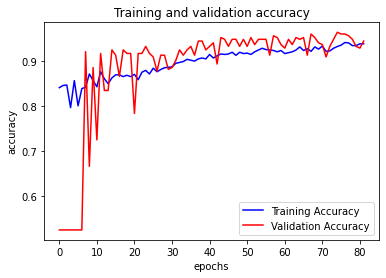

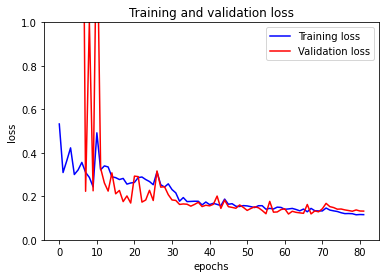

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.legend()
plt.figure() 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim([0, 1])
plt.legend() 
plt.show()

In [ ]:
X_test = X['img']['test']
y_test = test_labels
model.evaluate(x=X_test, y=y_test)

27/27 [==============================] - 2s 58ms/step - loss: 0.1390 - accuracy: 0.9385


[0.13898193836212158, 0.9384615421295166]

## Predictions

[0 1]
              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94       460
         1.0       0.94      0.93      0.93       385

    accuracy                           0.94       845
   macro avg       0.94      0.94      0.94       845
weighted avg       0.94      0.94      0.94       845



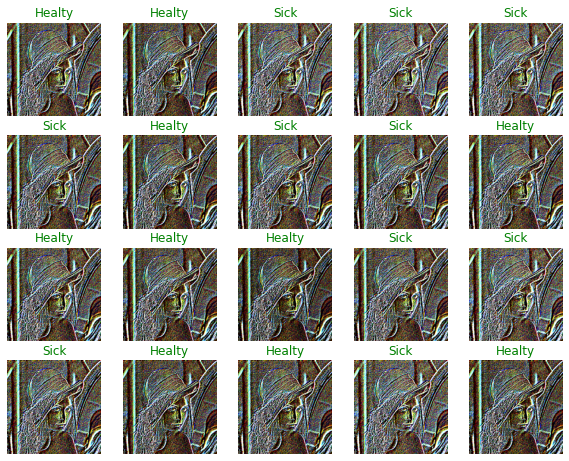

In [ ]:
y_predicted = model.predict(X_test)
pred_class = np.argmax(y_predicted, axis = 1)  
print(np.unique(pred_class))   
confusion_matrix(np.array(y_test[:,1]), pred_class)
print(sklearn.metrics.classification_report(np.array(y_test[:,1]), pred_class))

plt.figure(figsize=(10, 10))
for i in range(20):
  ax = plt.subplot(5, 5, i + 1)
  plt.imshow(X['img']['test'][i,:,:,:])
  if pred_class[i] == np.array(test_labels[:,1])[i]:
    color = 'green'
  else:
    color = 'red'
  
  plt.title(class_names[pred_class[i]], color = color)
  plt.axis("off")
  

In [ ]:
len(pred_class) - (pred_class == Y['test']).sum()

52

In [ ]:
len(pred_class)

845

# Create the new Dataset for PROLOG XAI

In [ ]:
# join the x_test with the y_pred
# get a copy 
new_data = X['ds']['test']

# add 'labels' array as new column in DataFrame
new_data['PRED_OBESE'] = pred_class

# export the dataset in .csv format
#new_data.to_csv('./neural_network_obese.csv', index=False, header=False)

# write facts on .pl file 
file_w = open(r'./cnn_target_obesity_database.pl', 'w')
column_name = list(new_data.columns)
for index, row in new_data.iterrows():
  line = f"a({row[column_name[0]].astype(int)},{row[column_name[1]].astype(int)},{row[column_name[2]].astype(float)},{row[column_name[3]].astype(float)},{row[column_name[4]].astype(int)},{row[column_name[5]].astype(int)},{row[column_name[6]].astype(int)},{row[column_name[7]].astype(int)},{row[column_name[8]].astype(int)},{row[column_name[9]].astype(int)},{row[column_name[10]].astype(int)},{row[column_name[11]].astype(int)},{row[column_name[12]].astype(int)},{row[column_name[13]].astype(int)},{row[column_name[14]].astype(int)},{row[column_name[15]].astype(int)},{row[column_name[17]].astype(int)})."
  file_w.write(line)
  file_w.write("\n")
file_w.close()

new_data


,Gender,Age,Height,Weight,FHO,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,OBESE,PRED_OBESE
0,1,35,1.77,85.00,1,1,3,3,2,0,3,0,2,1,3,0,0,0
1,1,27,1.83,71.00,1,1,2,3,2,0,2,0,3,2,3,0,0,0
2,1,25,1.76,117.37,1,1,1,3,2,0,2,0,1,1,2,3,1,1
3,0,21,1.80,152.47,1,1,3,3,2,0,2,0,1,1,2,3,1,1
4,1,26,1.77,114.10,1,1,2,3,2,0,2,0,1,1,2,3,1,1
